# MachineMax Technical Test - Model Building

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.preprocessing import MinMaxScaler
from Codebase.models import TimeSeriesModelEvaluator
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Loading Data

In [2]:
df = pd.read_csv('./data/time-series0.csv')

## Preprocessing Data

In [3]:
# Convert the timestamp to a numerical value
df['timestamp_asint'] = pd.to_datetime(df['timestamp']).astype('int64')

df.head()

,rms,state,timestamp,timestamp_asint
0,204.019477,States.IDLE,2021-01-01 00:00:00,1609459200000000000
1,110.575732,States.IDLE,2021-01-01 00:00:10,1609459210000000000
2,281.929994,States.IDLE,2021-01-01 00:00:20,1609459220000000000
3,247.890607,States.IDLE,2021-01-01 00:00:30,1609459230000000000
4,359.185049,States.IDLE,2021-01-01 00:00:40,1609459240000000000


In [4]:
# Encode the categorical state variable using one-hot encoding
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(df[['state']])
df[['States.ACTIVE', 'States.IDLE', 'States.OFF']] = y_encoded.toarray().astype(int)
df['state_encoded'] = np.argmax(y_encoded, axis=1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['timestamp_scaled', 'rms_scaled']] = scaler.fit_transform(df[['timestamp_asint', 'rms']])

In [6]:
df.columns = df.columns.map(str)
df.head()

,rms,state,timestamp,timestamp_asint,States.ACTIVE,States.IDLE,States.OFF,state_encoded,timestamp_scaled,rms_scaled
0,204.019477,States.IDLE,2021-01-01 00:00:00,1609459200000000000,0,1,0,1,0.000000,0.212337
1,110.575732,States.IDLE,2021-01-01 00:00:10,1609459210000000000,0,1,0,1,0.001391,0.115079
2,281.929994,States.IDLE,2021-01-01 00:00:20,1609459220000000000,0,1,0,1,0.002782,0.293428
3,247.890607,States.IDLE,2021-01-01 00:00:30,1609459230000000000,0,1,0,1,0.004172,0.257999
4,359.185049,States.IDLE,2021-01-01 00:00:40,1609459240000000000,0,1,0,1,0.005563,0.373837


## Model Building

Data will be split using TimeSeriesSplit, which performs cross-validation on the model as follows:

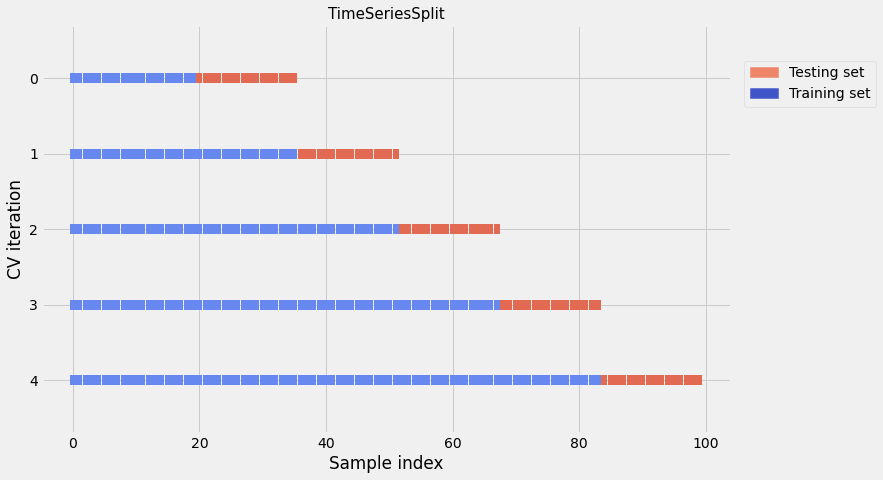

### Logistic Regression

In [7]:
# Train a logistic regression model
model = LogisticRegression()

evaluator = TimeSeriesModelEvaluator(model)

LR_metrics = evaluator.evaluate(
    X=df[['timestamp_scaled', 'rms_scaled']].values,
    y=df['state_encoded'].values
)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


AttributeError: 'LogisticRegression' object has no attribute 'best_params_'

#### Metrics

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

# Calculate the ROC AUC score for each class
auc_scores = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
print('Average ROC_AUC Score for all classes:', auc_scores)
# Compute ROC curve and ROC area for each class
roc_auc = dict()
# Binarize the output
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_bin = model.predict_proba(X_test)

# Compute ROC_AUC score for each class
for i in range(len(classes)):
    roc_auc[classes[i]] = roc_auc_score(y_test_bin[:, i], y_pred_bin[:, i])

print('ROC AUC per class:', roc_auc)

              precision    recall  f1-score   support

           0       0.99      0.77      0.86        94
           1       0.77      0.61      0.68       113
           2       0.17      1.00      0.29         9

    accuracy                           0.69       216
   macro avg       0.64      0.79      0.61       216
weighted avg       0.84      0.69      0.74       216

Average ROC_AUC Score for all classes: 0.9579537633712251
ROC AUC per class: {0: 0.964161144053017, 1: 0.9097001460606581, 2: 1.0}


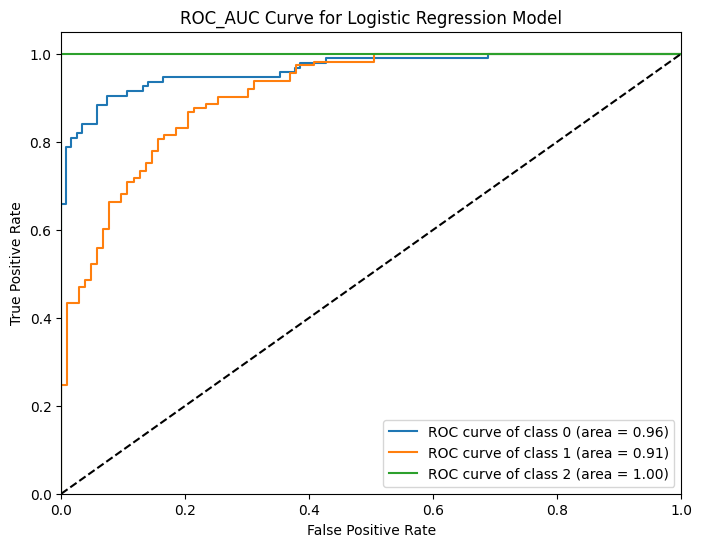

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
for i in range(len(classes)):
    fpr[classes[i]], tpr[classes[i]], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[classes[i]] = auc(fpr[classes[i]], tpr[classes[i]])
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[classes[i]], tpr[classes[i]], label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[classes[i]]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC Curve for Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

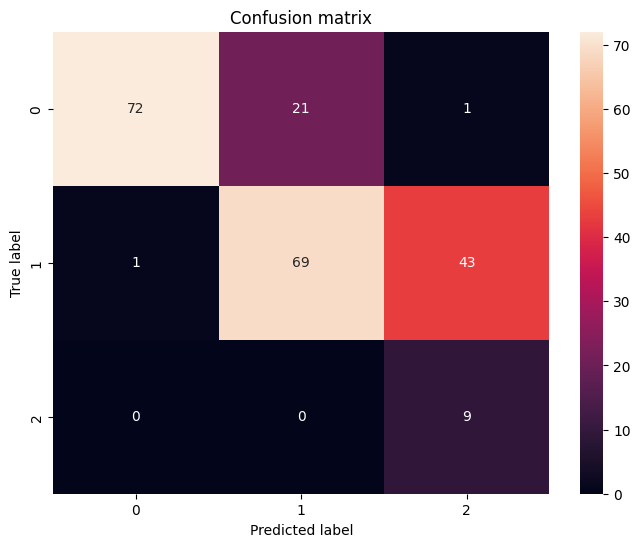

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### XGBoost

In [9]:
from xgboost import XGBClassifier

# Instantiate XGBoost classifier
xgb_model = XGBClassifier()

# Hyperparameters for XGBoost
# hyperparams = {
#     'learning_rate': [0.01, 0.1, 0.2, 0.3], # This parameter controls the step size shrinkage, which is used to prevent overfitting.
#     'max_depth': [3, 4, 5, 6], # This parameter controls the maximum depth of each tree.
#     'n_estimators': [50, 100, 200] # This parameter controls the number of estimators or trees in the model.
# }

# Instantiate the evaluator with the XGBoost classifier
evaluator = TimeSeriesModelEvaluator(xgb_model)

# Use your dataframe's feature and target columns as X and y
X = df[['timestamp_scaled', 'rms_scaled']].values
y = df['state_encoded'].values

# Evaluate the model
metrics = evaluator.evaluate(X, y, n_splits=5)

# print the metrics
for key, value in metrics.items():
    print(f"{key}: \n{value}\n")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


AttributeError: 'XGBClassifier' object has no attribute 'best_params_'